## 4.1.7  CNN(Yoon Kim) 분류 모델

In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import os
import json

from tqdm import tqdm

## 시각화

In [64]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 학습 데이터 파일 로드

In [65]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [67]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = None

with open(DATA_IN_PATH + DATA_CONFIGS, 'r') as f:
    prepro_configs = json.load(f)

## 모델 정의

In [68]:
model_name = 'malstm'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

In [69]:
kargs = {'vocab_size': prepro_configs['vocab_size']+1,
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

# VOCAB_SIZE = prepro_configs['vocab_size']+1

# print(len(prepro_configs['vocab']), VOCAB_SIZE) #check the number of vocab

In [70]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=model_name) # name=model name?
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
        
    def build_graph(self, input_shape):
        input_shape_wo_batch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_wo_batch)
        
        _ = self.call(inputs)

In [71]:
model = CNNClassifier(**kargs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# For Summary
model.build_graph(input_shape=(BATCH_SIZE, max_length))
model.summary()

Model: "malstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 174, 128)          9480448   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 172, 100)          38500     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 171, 100)          51300     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 170, 100)          64100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 174, 128)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               75250

In [75]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

    
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

./data_out/malstm -- Folder already exists 

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22016/22500 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9110
Epoch 00001: val_accuracy improved from -inf to 0.88680, saving model to ./data_out/malstm/weights.01-0.30.hdf5
22500/22500 [==============================] - 29s 1ms/sample - loss: 0.2265 - accuracy: 0.9108 - val_loss: 0.2958 - val_accuracy: 0.8868
Epoch 2/2
22016/22500 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9531
Epoch 00002: val_accuracy did not improve from 0.88680
22500/22500 [==============================] - 31s 1ms/sample - loss: 0.1336 - accuracy: 0.9533 - val_loss: 0.3237 - val_accuracy: 0.8800


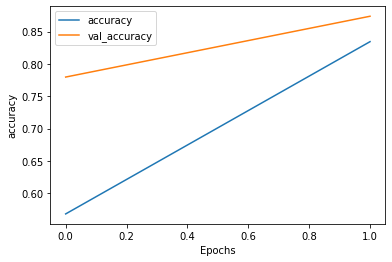

In [73]:
plot_graphs(history, 'accuracy')

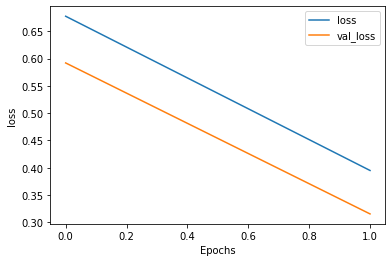

In [74]:
plot_graphs(history, 'loss')

## 캐글 평가 데이터셋 만들기

In [57]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [58]:
model.load_weights(DATA_OUT_PATH + 'weights.01-0.32.data-00000-of-00001')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./data_out/weights.01-0.32.data-00000-of-00001

In [22]:
BLOCK_SIZE = 500

predictions = [model(test_input[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE]).numpy() \
               for i in tqdm(range(test_input.shape[0] // BLOCK_SIZE))]

  0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'numpy'

In [ ]:
predictions = np.concatenate(predictions, axis=-2).squeeze(-1)

In [ ]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

In [ ]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)} )
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3 )